In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import mylibrary.datasets as datasets
import mylibrary.splinelib as spline
import matplotlib
%matplotlib inline

In [2]:
default0 = plt.rcParams['figure.figsize']
default0

[6.0, 4.0]

(400, 2) (400, 1)


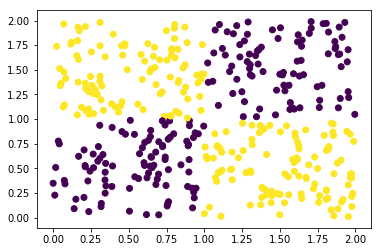

In [3]:
T = 1.
F = 0.

xxx = np.array([[F, F],
      [F, T],
      [T, F],
      [T, T],])
yyy = np.array([[F],[T],[T],[F]])

x = []
y = []
n_data = 400
for i in range(n_data):
    index = np.random.randint(low=0, high=4)
    xx = xxx[index] + np.random.uniform(low=0., high=1, size=xxx[0].size)
#     xx = xxx[index] + np.random.normal(loc=0., scale=0.21, size=xxx[0].size)
    x.append(xx)
    y.append(yyy[index])
x, y = np.array(x), np.array(y)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1))

In [4]:
colors = ['r', 'y', 'g', 'b']
h = 0.01
xx, yy = np.meshgrid(np.arange(x[:,0].min(), x[:,0].max(), h), np.arange(x[:,1].min(), x[:,1].max(), h))
xxyy = np.c_[xx.ravel(), yy.ravel()]

In [5]:
input_size = 2
hidden_1 = 2
output_size = 1
learning_rate = 0.001

optimizer = tnn.Adam(learning_rate)
layer1 = tnn.LinearLayer(input_size, hidden_1, optimizer=optimizer)
layer2 = spline.SplineVectorLayer(hidden_1, max_points=3)  # 2 -> Linear; 3 -> DoubleRelu
layer3 = tnn.NonLinearLayer(hidden_1, output_size, activation=tnn.Sigmoid(), optimizer=optimizer)

layer3_res = tnn.WeightsLayer(hidden_1, hidden_1-output_size, optimizer=optimizer)
layer3_resT = tnn.WeightsLayer(hidden_1-output_size, hidden_1)
# layer3_resT.weights = np.vstack([layer3_res.weights.T, layer3.weights.T])
layer3_resT.weights = layer3_res.weights.T

-------------------------
epoch 0
Loss 0.7240775758425672

-------------------------
epoch 100
Loss 0.6978334823747444

-------------------------
epoch 200
Loss 0.6927814622867325

-------------------------
epoch 300
Loss 0.6870162838691874

-------------------------
epoch 400
Loss 0.6770503815801251

-------------------------
epoch 500
Loss 0.6565270956571101

-------------------------
epoch 600
Loss 0.6214887791281797

-------------------------
epoch 700
Loss 0.5734504096669201

-------------------------
epoch 800
Loss 0.5205476798408801

-------------------------
epoch 900
Loss 0.46865817590364517

-------------------------
epoch 1000
Loss 0.42385127667534833

-------------------------
epoch 1100
Loss 0.38745313723765434

-------------------------
epoch 1200
Loss 0.35706457797282254

-------------------------
epoch 1300
Loss 0.32986757241179177

-------------------------
epoch 1400
Loss 0.30493787234904174

-------------------------
epoch 1500
Loss 0.28163751225415545

-------------

/media/tsuman/98D2644AD2642EA6/Neural_Network/Notebooks/Experimentals/Credit_Assignment/Spline_Neural_Net_dynamic/mylibrary/nnlib.py:36: RuntimeWarning: divide by zero encountered in log
  return -((target * np.log(output) + (1 - target) * np.log(1 - output)).sum(axis=1)).mean()
/media/tsuman/98D2644AD2642EA6/Neural_Network/Notebooks/Experimentals/Credit_Assignment/Spline_Neural_Net_dynamic/mylibrary/nnlib.py:36: RuntimeWarning: invalid value encountered in multiply
  return -((target * np.log(output) + (1 - target) * np.log(1 - output)).sum(axis=1)).mean()


-------------------------
epoch 6300
Loss nan

-------------------------
epoch 6400
Loss nan

-------------------------
epoch 6500
Loss nan

-------------------------
epoch 6600
Loss nan

-------------------------
epoch 6700
Loss nan

-------------------------
epoch 6800
Loss nan

-------------------------
epoch 6900
Loss nan

-------------------------
epoch 7000
Loss nan

-------------------------
epoch 7100
Loss nan

-------------------------
epoch 7200
Loss nan

-------------------------
epoch 7300
Loss nan

-------------------------
epoch 7400
Loss nan

-------------------------
epoch 7500
Loss nan

-------------------------
epoch 7600
Loss nan

-------------------------
epoch 7700
Loss nan

-------------------------
epoch 7800
Loss nan

-------------------------
epoch 7900
Loss nan

-------------------------
epoch 8000
Loss nan

-------------------------
epoch 8100
Loss nan

-------------------------
epoch 8200
Loss nan

-------------------------
epoch 8300
Loss nan

-------------

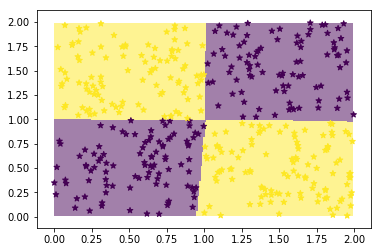

In [6]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(20000):
    a1 = layer1.forward(x)
    a2 = layer2.forward(a1)
    yout = layer3.forward(a2)
        
    loss = tnn.CrossEntropyBinary.loss(yout, y)
    dy = tnn.CrossEntropyBinary.del_loss(yout, y)
    
    da2 = layer3.backward(dy)
    da1 = layer2.backward(da2)
    dx = layer1.backward(da1)

    res = layer3_res.forward(a2)
    a20_ = layer3_resT.forward(res)
    a21_ = (layer3.zee-layer3.bias)@np.linalg.pinv(layer3.weights)
    a2_ = a20_+ a21_
    
    loss2 = tnn.MseLoss.loss(a2_, a2)
    da2_ = tnn.MseLoss.del_loss(a2_, a2)
    
    dres = layer3_resT.backward(da2_)
    da2 = layer3_res.backward(dres)
    
    
    
    layer1.update()
    layer2.update()
    layer3.update()
    layer3_res.update()
    layer3_resT.weights = layer3_res.weights.T
  
    
    if step % 100 == 0:
        layer2._maintain_good_spline_()
        
        print('-------------------------')
        print("epoch", step)
        print("Loss", loss)

        ax.clear()        
        a1 = layer1.forward(xxyy)
        a2 = layer2.forward(a1)
        classxy = layer3.forward(a2)
        classxyi = (classxy > 0.5).astype(int)
        plt.imshow(classxyi.reshape(xx.shape), interpolation='nearest',
                   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                   alpha=0.5,
                   aspect='auto', origin='lower')
        plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), marker='*')            
        fig.canvas.draw()
        
        plt.pause(0.01)
        print()
        if loss < 0.0025:
            print('fitted to our expectation')
            plt.pause(50)
            break

In [7]:
loss2

1.072465646346288e-07

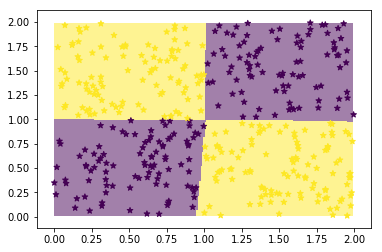

In [8]:
%matplotlib inline
a1 = layer1.forward(xxyy)
a2 = layer2.forward(a1)
classxy = layer3.forward(a2)
classxyi = (classxy > 0.5).astype(int)
plt.imshow(classxyi.reshape(xx.shape), interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           alpha=0.5,
           aspect='auto', origin='lower')
plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), marker='*')  

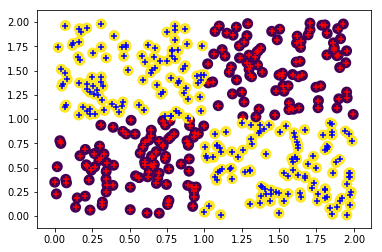

In [9]:
a1 = layer1.forward(x)
a2 = layer2.forward(a1)
yout = layer3.forward(a2)
out = (yout>0.5).astype(int)
plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), lw=5)
plt.scatter(x[:,0], x[:, 1], c=out.reshape(-1), marker='+', cmap=matplotlib.colors.ListedColormap(colors))

## Visualize neural network layers 

In [10]:
layer3.input.shape

(400, 2)

[-6.88954872  2.09611545 11.72718127]


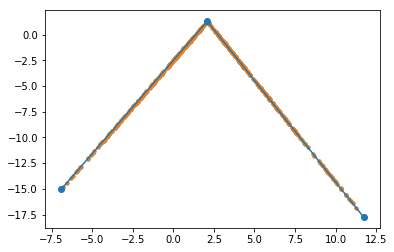

[-17.42103307   0.49468802  18.63827432]


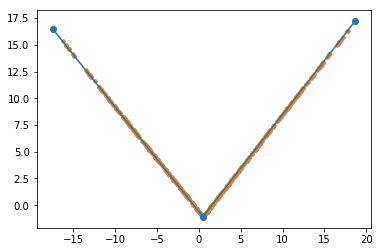

In [11]:
for i in range(layer3.input.shape[1]):
    a1 = layer2.input
    a2 = layer3.input
    da2 = layer2.del_output
    a2_ = a2 - da2
    plt.scatter(a1[:, i], a2_[:, i], marker='.')
    plt.scatter(a1[:, i], a2[:, i], marker='.')
    plt.plot(layer2.spline_list[i].X,  layer2.spline_list[i].Y, marker='o')
    print(layer2.spline_list[i].X)
    da2[:,i].mean(), da2[:,i].var()
    plt.show()

In [12]:
da2.mean(axis=0)

array([8.67745820e-06, 9.05611902e-06])

In [13]:
da2.std(axis=0)

array([0.01245854, 0.01300219])

In [14]:
# layer2._increase_pieces_()

## Reverse Propagation

#### Reversing over sigmoid

In [15]:
pred = layer3.output > 0.5

In [16]:
def logit(x, epsilon=1e-15):
    x = np.clip(x, epsilon, 1-epsilon)
    y = np.log(x/(1-x))
    return y

In [17]:
# l3z_ = logit(layer3.output - layer3.del_output)
l3z_ = logit(y)

In [18]:
pred_ = tnn.Sigmoid().forward(l3z_) > 0.5
(pred != pred_).astype(int).sum()  # number of mistakes made
# pred - pred_

0

In [19]:
(y != pred_).astype(int).sum()  # number of mistakes made

0

#### Reversing over layer 3 and layer3_res

In [20]:
l3wi = np.linalg.pinv(layer3.weights)
layer3.weights, l3wi

(array([[9.48977304],
        [9.90389351]]), array([[0.05043918, 0.05264027]]))

In [21]:
l2a_0 = (l3z_ - layer3.bias)@l3wi

In [22]:
## Residual required for matrix inversion
res

array([[ -8.05122446],
       [ -1.66998099],
       [-10.63523803],
       [ -6.69010015],
       [ -8.41416583],
       [ -7.37751881],
       [-11.37783955],
       [ -7.37371567],
       [ -8.46504294],
       [ -5.84021213],
       [ -5.85628876],
       [ -8.00494812],
       [ -1.24284855],
       [  0.35236162],
       [ -6.12232839],
       [-13.46701215],
       [ -8.85522218],
       [ -8.09396961],
       [-11.74561223],
       [ -5.89746409],
       [  0.70437803],
       [-12.23972422],
       [ -3.7267551 ],
       [ -2.94252954],
       [ -7.84531601],
       [ -5.51726838],
       [ -4.96412335],
       [ -8.01997912],
       [ -5.14323397],
       [ -2.95853074],
       [ -9.35164382],
       [ -6.81650117],
       [ -6.05007005],
       [ -8.14975201],
       [ -5.73284971],
       [ -8.76926012],
       [ -6.89036149],
       [ -8.11411195],
       [ -7.05132368],
       [ -8.3194258 ],
       [ -0.94864034],
       [ -3.42262858],
       [ -6.10820661],
       [ -9

In [23]:
l2a_1 = layer3_resT.forward(res)
l2a_ = l2a_0 + l2a_1

In [24]:
pred1_ = tnn.Sigmoid().forward(l2a_@layer3.weights + layer3.bias) > 0.5
(pred != pred1_).astype(int).sum()

0

In [25]:
pred1_ = tnn.Sigmoid().forward(layer2.output@layer3.weights + layer3.bias) > 0.5
(pred != pred1_).astype(int).sum()

0

In [26]:
(np.abs(layer2.output - l2a_)).mean()  ## here was the most loss in information backward
## NOW SOLVED

1.9869450272671252

#### Reversing over layer 2

In [27]:
layer2.output - l2a_

array([[ 1.27851640e+00,  1.33432749e+00],
       [-1.47911255e+00, -1.54362381e+00],
       [-2.44554336e+00, -2.55222330e+00],
       [ 1.46168727e+00,  1.52550328e+00],
       [ 3.14657065e+00,  3.28386313e+00],
       [ 7.00264930e-01,  7.30858772e-01],
       [ 8.77613024e-02,  9.15881050e-02],
       [-1.65390393e+00, -1.72601291e+00],
       [ 2.94910896e+00,  3.07778578e+00],
       [ 1.07067747e+00,  1.11742400e+00],
       [ 9.27150185e-01,  9.67658629e-01],
       [-2.87759603e+00, -3.00309774e+00],
       [ 1.56913575e+00,  1.63764718e+00],
       [ 1.58733799e+00,  1.65664050e+00],
       [ 7.62793221e-01,  7.96127342e-01],
       [-6.31641194e+00, -6.59198881e+00],
       [ 5.08437536e+00,  5.30624601e+00],
       [-4.18211614e-01, -4.36394965e-01],
       [ 6.82317885e+00,  7.12092188e+00],
       [ 5.28528060e-01,  5.51647965e-01],
       [ 1.64466361e+00,  1.71645620e+00],
       [ 9.56114091e-01,  9.97851428e-01],
       [ 1.59409843e+00,  1.66368592e+00],
       [ 5.

In [28]:
def reverse_spline(self:spline.Spline1D, y, whichPiece = None):
    xinp = np.zeros_like(self.input)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        xinp += xpossible*self.rangeX[i]
    return xinp
sp0x_ = reverse_spline(layer2.spline_list[0], l2a_[:,0])
sp1x_ = reverse_spline(layer2.spline_list[1], l2a_[:,1])

In [29]:
sp0x = layer2.spline_list[0].input
sp1x = layer2.spline_list[1].input

In [30]:
np.abs(sp0x - sp0x_).mean()

1.0249966759743985

In [31]:
## reverse spline test
t0 = reverse_spline(layer2.spline_list[0], layer2.spline_list[0].output)
t1 = layer2.spline_list[0].input
np.abs(t0-t1).sum()  # works fine for reversing the spline

2.6645352591003757e-14

In [32]:
import copy
l2 = copy.deepcopy(layer2)
sp0y_ = l2.spline_list[0].forward(sp0x_)
sp1y_ = l2.spline_list[1].forward(sp1x_)
np.abs(l2a_[:,0] - sp0y_).mean()   ### the inverse of the spline is doing well

0.012853468283026104

In [33]:
layer2 is l2

False

In [34]:
l1a = layer2.input
l1a_ = np.c_[sp0x_, sp1x_]

In [35]:
np.abs(l1a_ - l1a).mean() ## very low error here as well

1.534542962022351

In [36]:
pred1_ = tnn.Sigmoid().forward(l2.forward(l1a_)@layer3.weights + layer3.bias) > 0.5
(pred != pred1_).astype(int).sum()

0

#### Reversing over layer 1

In [37]:
l1wi = np.linalg.pinv(layer1.weights)
layer1.weights, l1wi

(array([[  4.84011605,   8.56707758],
        [  5.24042575, -10.17825559]]), array([[ 0.10809639,  0.09098515],
        [ 0.05565503, -0.05140361]]))

In [38]:
xx_ = (l1a_ - layer1.bias)@l1wi

In [39]:
np.abs((xx_@layer1.weights + layer1.bias) - l1a_).sum()  # almost equal

2.6117441542794495e-12

In [40]:
pred1_ = tnn.Sigmoid().forward(l2.forward(xx_@layer1.weights + layer1.bias)@layer3.weights + layer3.bias) > 0.5
(pred != pred1_).astype(int).sum()

0

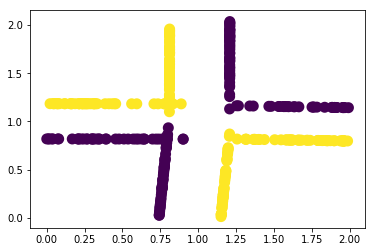

In [41]:
plt.scatter(xx_[:,0], xx_[:, 1], c=y.reshape(-1), lw=5)

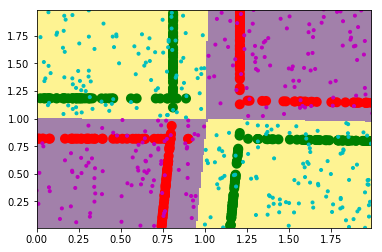

In [42]:
out = (pred1_).astype(int)
plt.scatter(xx_[:,0], xx_[:, 1], c=out.reshape(-1), marker='o', lw=4,
            cmap=matplotlib.colors.ListedColormap(['r', 'g']))
plt.scatter(x[:,0], x[:, 1], c=out.reshape(-1), marker='.', cmap=matplotlib.colors.ListedColormap(['m','c']))
plt.imshow(classxyi.reshape(xx.shape), interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           alpha=0.5,
           aspect='auto', origin='lower')

In [43]:
np.abs(xx_ - x).mean()

0.11053257218875215

## Visualizing Residual

In [44]:
res

array([[ -8.05122446],
       [ -1.66998099],
       [-10.63523803],
       [ -6.69010015],
       [ -8.41416583],
       [ -7.37751881],
       [-11.37783955],
       [ -7.37371567],
       [ -8.46504294],
       [ -5.84021213],
       [ -5.85628876],
       [ -8.00494812],
       [ -1.24284855],
       [  0.35236162],
       [ -6.12232839],
       [-13.46701215],
       [ -8.85522218],
       [ -8.09396961],
       [-11.74561223],
       [ -5.89746409],
       [  0.70437803],
       [-12.23972422],
       [ -3.7267551 ],
       [ -2.94252954],
       [ -7.84531601],
       [ -5.51726838],
       [ -4.96412335],
       [ -8.01997912],
       [ -5.14323397],
       [ -2.95853074],
       [ -9.35164382],
       [ -6.81650117],
       [ -6.05007005],
       [ -8.14975201],
       [ -5.73284971],
       [ -8.76926012],
       [ -6.89036149],
       [ -8.11411195],
       [ -7.05132368],
       [ -8.3194258 ],
       [ -0.94864034],
       [ -3.42262858],
       [ -6.10820661],
       [ -9

In [45]:
res.mean(), res.std()

(-7.018937101958864, 3.1595897773396433)

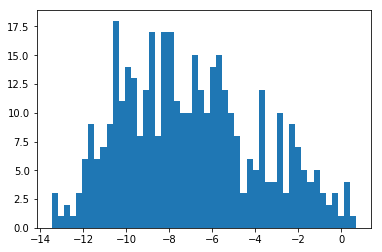

In [54]:
plt.hist(res, bins=50)
plt.show()